In [1]:
import matplotlib.pyplot as pl
import numpy as np
from scipy.optimize import minimize, curve_fit
import sys
from datetime import datetime

sys.path.append('/home/bart/meteo/models/LS2D')
import ls2d

In [2]:
"""
Read ERA5 with (LS)2D.
"""
settings = {
    'central_lat' : 51.97,
    'central_lon' : 4.92,
    'area_size'   : 1,
    'case_name'   : 'cabauw',
    'era5_path'   : '/home/scratch1/bart/LS2D_ERA5/',
    'era5_expver' : 1,   # 1=normal ERA5, 5=ERA5 near-realtime
    'start_date'  : datetime(year=2016, month=8, day=15, hour=6),
    'end_date'    : datetime(year=2016, month=8, day=15, hour=18),
    'write_log'   : False,
    'data_source' : 'CDS'
    }

era = ls2d.Read_era5(settings)
era.calculate_forcings(n_av=0, method='2nd')
z = np.arange(10, 4000, 20.)
les_input = era.get_les_input(z)

Reading ERA5 from 2016-08-15 06:00:00 to 2016-08-15 18:00:00 [23-01: 13:05]
Calculating large-scale forcings [23-01: 13:05]
 - Using nearest lat/lon = 51.97/4.93 (requested = 51.97/4.92), distance ~= 0.5 km
 - Averaging ERA5 over a 0.25°×0.25° spatial area.
 - Selected grid point is over land.


### Single layer free-tropospheric lapse rate.

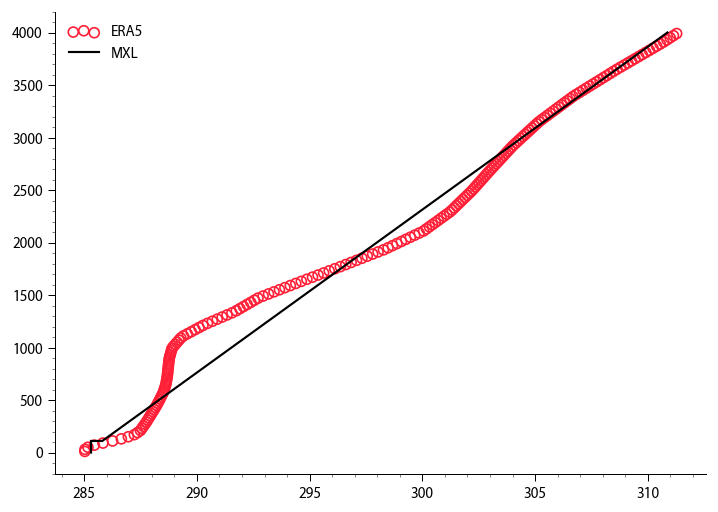

In [3]:
def mxl_profile(bulk_value, zi, delta, gamma, zmax=4000):
    v1 = bulk_value + delta
    v2 = v1 + (zmax - zi) * gamma

    z = np.array([0, zi, zi, zmax])
    v = np.array([bulk_value, bulk_value, v1, v2])

    return v,z

# Target profiles ERA5.
thl_ref = les_input['thl'][0,:].values
qt_ref  = les_input['qt' ][0,:].values
thv_ref = thl_ref + 0.61 * thl_ref * qt_ref 

"""
1. Estimate boundary layer depth from max gradient in virtual potential temperature.
   Should we put a max height here, e.g. 500 m for early-morning sounding, to prevent
   "finding" the inversion of the previous day above the residual layer?
"""
thv_grad = np.gradient(thv_ref) / (z[1] - z[0])
kzi = thv_grad.argmax()
zi = z[kzi]

"""
2. Optimize bulk mixed-layer value.
   Maybe a simple mean from the ERA5 profile is sufficient?
"""
def bulk_func(z, bulk_value):
    return np.full(z.size, bulk_value)

mask = (z < zi)
popt, pcov = curve_fit(bulk_func, z[mask], thl_ref[mask])
bulk_thl = popt[0]

"""
3. Optimize temperature jump and lapse rate free troposphere.
"""
mask = z > (zi + 250)

bounds = (
    [bulk_thl+0.5, 0],
    [bulk_thl+20,  0.01]
)

def ft_func(z, plus_value, gamma):
    return plus_value + gamma * z

popt, pcov = curve_fit(ft_func, z[mask]-zi, thl_ref[mask], bounds=bounds)

dthl = popt[0] - bulk_thl
gamma_thl = popt[1]

"""
Create mixed-layer profile and plot.
"""
thl_mxl, z_mxl = mxl_profile(bulk_thl, zi, dthl, gamma_thl)

pl.figure()
pl.scatter(thl_ref, z, color='C0', facecolor='none', label='ERA5')
pl.plot(thl_mxl, z_mxl, color='k', label='MXL')
pl.legend()

## Multi-layer free-troposphere.
Beter for conditions with old mixed-layer on top stable boundary layer?

Text(0.5, 0, 'dthv/dz (K/m)')

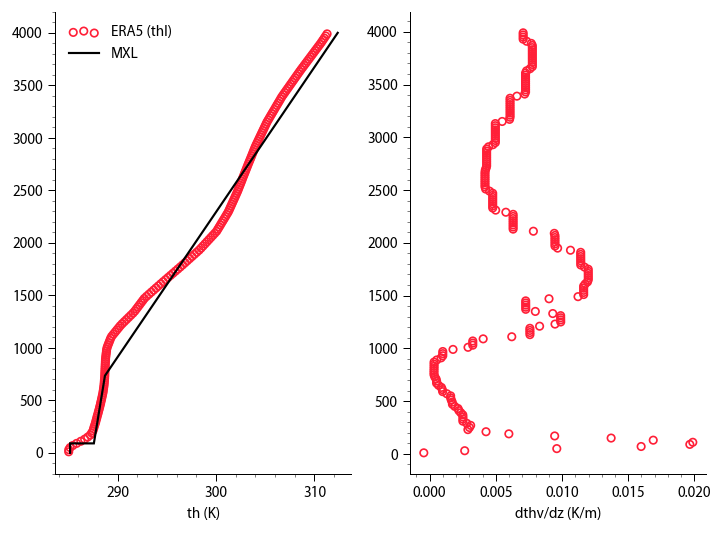

In [6]:
t = 0
zmax_grad = 2500

def mxl_profile_multi(bulk_value, zi, delta, gamma1, z1, gamma2, zmax=4000):
    v1 = bulk_value + delta
    v2 = v1 + (z1 - zi) * gamma1
    v3 = v2 + (zmax - z1) * gamma2

    z = np.array([0, zi, zi, z1, zmax])
    v = np.array([bulk_value, bulk_value, v1, v2, v3])

    return v,z

# Target profiles ERA5.
thl_ref = les_input['thl'][t,:].values
qt_ref  = les_input['qt' ][t,:].values
thv_ref = thl_ref + 0.61 * thl_ref * qt_ref 

"""
1. Estimate boundary layer depth.
   For stable conditions, use height of max(dthv/dz) over the lowest 500 m.
   For unstable conditions, use a non-entraining parcel.
"""
thv_grad = np.gradient(thv_ref) / (z[1] - z[0])

if thv_grad[0] >= 0:
    kzi = thv_grad[z < zmax_grad].argmax()
else:
    kzi = np.where(thv_ref > thv_ref[0]+0.5)[0][0]
zi = z[kzi]

"""
2. Optimize bulk mixed-layer value.
   Maybe a simple mean from the ERA5 profile is sufficient?
"""
def bulk_func(z, bulk_value):
    return np.full(z.size, bulk_value)

mask = (z < zi)
popt, pcov = curve_fit(bulk_func, z[mask], thl_ref[mask])
bulk_thl = popt[0]

"""
3. Optimize temperature jump and lapse rate free troposphere.
"""
mask = z > (zi + 250)

bounds = (
    [bulk_thl+0.5, 0,    zi+100, 0],
    [bulk_thl+20,  0.01, 4000,   0.01]
)

def ft_func_2layer(z, plus_value, gamma1, z1, gamma2):
    return np.where(
        z <= z1,
        plus_value + gamma1 * z,
        plus_value + gamma1 * z1 + gamma2 * (z-z1))

popt, pcov = curve_fit(ft_func_2layer, z[mask]-zi, thl_ref[mask], bounds=bounds)
dthl = popt[0] - bulk_thl
gamma1 = popt[1]
z1 = popt[2]
gamma2 = popt[3]


"""
Create mixed-layer profile and plot.
"""
thl_mxl, z_mxl = mxl_profile_multi(bulk_thl, zi, dthl, gamma1, z1, gamma2)

pl.figure()
pl.subplot(121)
pl.scatter(thl_ref, z, s=20, color='C0', facecolor='none', label='ERA5 (thl)')
#pl.scatter(thv_ref, z, s=20, color='C1', alpha=0.5, facecolor='none', label='ERA5 (thv)')
pl.plot(thl_mxl, z_mxl, color='k', label='MXL')
pl.xlabel('th (K)')
pl.legend()

pl.subplot(122)
pl.scatter(thv_grad, z, s=20, color='C0', facecolor='none', label='ERA5')
pl.xlabel('dthv/dz (K/m)')